In [1]:
import os
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
%matplotlib inline

In [2]:
images_dir ='./data/after_cut/images_cut/'
masks_dir = './data/after_cut/labels_cut/'

In [3]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size=9, replace=False)

In [4]:
print(len(images_listdir))
print(len(masks_listdir))

100
100


In [5]:
image_size=512
input_image_size=(512,512)

In [6]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [7]:
number=200

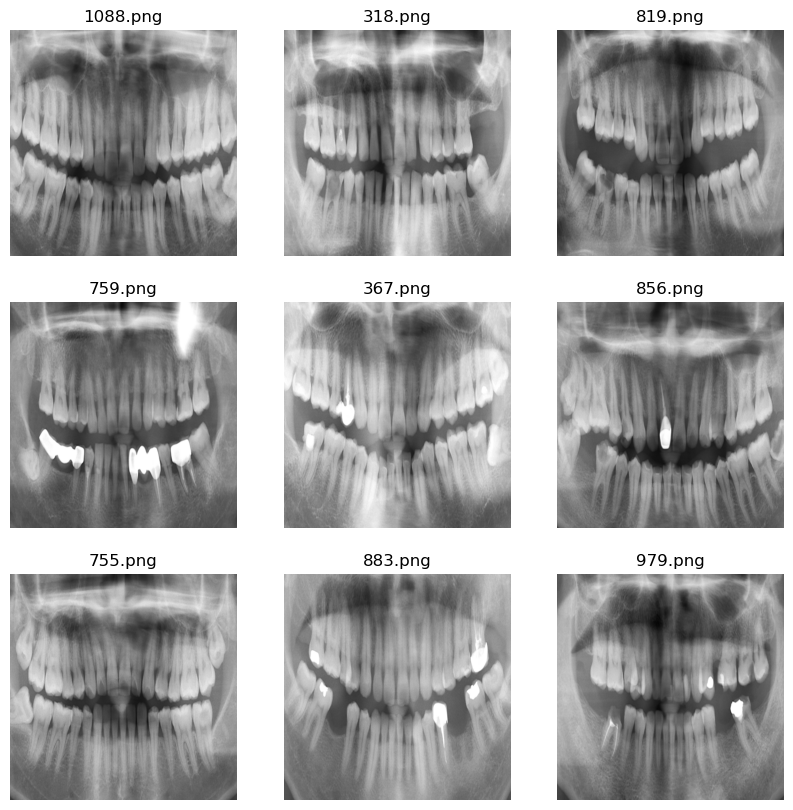

In [8]:
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

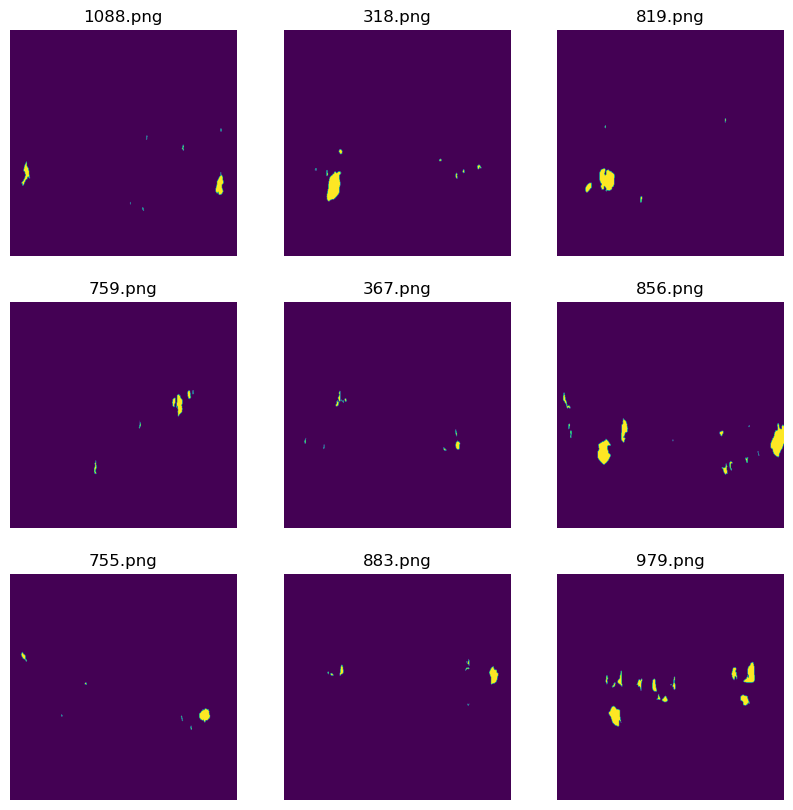

In [9]:
fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file = random_images[i]
        if os.path.exists(os.path.join(masks_dir, file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('Mask does not exist for:', file)

In [10]:
# 데이터셋 배열 초기화
MASKS = np.zeros((1, image_size, image_size, 1), dtype=bool)
IMAGES = np.zeros((1, image_size, image_size, 3), dtype=np.uint8)

In [11]:
# 이미지와 마스크 로드
number = 200  # 불러올 이미지의 개수
for file in images_listdir[:number]:
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512, 512, 1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except Exception as e:
        print("Error loading file:", file, e)
        continue


In [12]:
images = np.array(IMAGES)[1:number + 1]
masks = np.array(MASKS)[1:number + 1]
print(images.shape, masks.shape)

(100, 512, 512, 3) (100, 512, 512, 1)


In [13]:
# 학습/테스트 데이터 분리
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)
print(len(images_train), len(masks_train))

60 60


In [14]:
print(len(images_train), len(masks_train))

60 60


In [15]:
# UNet 모델 정의
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)


In [16]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        skip = self.conv(x)
        pool = self.pool(skip)
        return skip, pool

In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)
    
    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

In [18]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = EncoderBlock(3, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        
        self.bridge = ConvBlock(512, 1024)
        
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        skip1, x = self.enc1(x)
        skip2, x = self.enc2(x)
        skip3, x = self.enc3(x)
        skip4, x = self.enc4(x)
        
        x = self.bridge(x)
        
        x = self.dec1(x, skip4)
        x = self.dec2(x, skip3)
        x = self.dec3(x, skip2)
        x = self.dec4(x, skip1)
        
        x = self.final_conv(x)
        return self.sigmoid(x)

In [19]:
# 모델 인스턴스화, 손실 함수 및 옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

c:\Users\KDP-23\anaconda3\envs\TORCH_CV_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# 데이터셋 텐서 변환
images_train = torch.from_numpy(images_train.transpose(0, 3, 1, 2)).float().to(device)

In [21]:
masks_train = torch.from_numpy(masks_train.transpose(0, 3, 1, 2)).float().to(device) / 255.0
masks_test = torch.from_numpy(masks_test.transpose(0, 3, 1, 2)).float().to(device) / 255.0

In [22]:
# 모델 학습
epochs = 60
batch_size = 8
for epoch in range(epochs):
    unet_model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, len(images_train), batch_size):
        x_batch = images_train[i:i+batch_size]
        y_batch = masks_train[i:i+batch_size]

        optimizer.zero_grad()
        y_pred = unet_model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Accuracy 계산
        predictions = (y_pred > 0.5).float()  # 0.5 이상을 1로, 미만을 0으로 설정
        correct += (predictions == y_batch).sum().item()
        total += y_batch.numel()  # 총 원소 개수

    epoch_accuracy = correct / total  # Accuracy 계산
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(images_train):.4f}, Accuracy: {epoch_accuracy:.4f}")

    # 예측 및 결과 시각화
    unet_model.eval()
    images_test = torch.from_numpy(images_test.transpose(0, 3, 1, 2)).float().to(device)
    with torch.no_grad(): 
        unet_predict = unet_model(images_test).cpu().numpy()


Epoch [1/60], Loss: 0.0737, Accuracy: 0.9044
Epoch [2/60], Loss: 0.0631, Accuracy: 0.9828


TypeError: transpose() received an invalid combination of arguments - got (int, int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [ ]:
# 예측 시각화 함수
def show_result(idx, og, unet, target, p):
    fig, axs = plt.subplots(1, 3, figsize=(12, 12))
    axs[0].set_title("Original " + str(idx))
    axs[0].imshow(og.transpose(1, 2, 0))
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>" + str(p))
    axs[1].imshow(unet.squeeze(), cmap="gray")
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target.squeeze(), cmap="gray")
    axs[2].axis('off')
    plt.show()

In [ ]:
thresholds = [0.6, 0.7, 0.8, 0.9]
for idx in random.sample(range(len(unet_predict)), 3):
    for r in thresholds:
        unet_predict_thresh = (unet_predict[idx] > r).astype(np.uint8)
        show_result(idx, images_test[idx].cpu().numpy(), unet_predict_thresh, masks_test[idx], r)